In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import pickle
import re

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)

MAIN_COLOR = "#fec41a"

from nltk import ngrams

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

import spacy


# Exploratory data analysis

### 1. Load data and merge it

In [2]:
"""
Load dataframe
"""

lyrics_df = pd.read_csv("../lyrics/Lyrics_MichaelJackson_clean.csv")
spotify_df = pickle.load(open("../Julien/mj_df.pickle", "rb"))


"""
Helpers
"""

def remove_parentheses(text):
    return re.sub(r'\([^)]*\)', '', text)

assert remove_parentheses("remove (parentheses)").strip() == "remove"


spotify_df['name_track_clean'] = spotify_df['name_track'].apply(remove_parentheses) 
spotify_df.head()

,name_track,duration_ms,explicit,artists_track,artists_track_uri,featuring,track_number,disc_number,name_album,artists_album,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,name_track_clean
0,This Place Hotel (a.k.a. Heartbreak Hotel),343413,False,[The Jacksons],[spotify:artist:2yrbLiuBmc9j81lTX3XUuI],False,1,1,Scream,[{'external_urls': {'spotify': 'https://open.s...,...,-4.085,0,0.1030,0.2430,0.000142,0.1170,0.582,97.005,4,This Place Hotel
1,Thriller,358053,False,[Michael Jackson],[spotify:artist:3fMbdgg4jU18AjLCKBhRSm],False,2,1,Scream,[{'external_urls': {'spotify': 'https://open.s...,...,-3.725,1,0.0738,0.0816,0.000108,0.8470,0.721,118.421,4,Thriller
2,Blood on the Dance Floor,253373,False,[Michael Jackson],[spotify:artist:3fMbdgg4jU18AjLCKBhRSm],False,3,1,Scream,[{'external_urls': {'spotify': 'https://open.s...,...,-2.767,1,0.0764,0.0148,0.009780,0.0623,0.520,108.980,4,Blood on the Dance Floor
3,Somebody's Watching Me - Single Version,237760,False,[Rockwell],[spotify:artist:3xs0LEzcPXtgNfMNcHzLIP],False,4,1,Scream,[{'external_urls': {'spotify': 'https://open.s...,...,-4.128,0,0.0324,0.0409,0.000081,0.1320,0.804,124.091,4,Somebody's Watching Me - Single Version
4,Dirty Diana - 2012 Remaster,280946,False,[Michael Jackson],[spotify:artist:3fMbdgg4jU18AjLCKBhRSm],False,5,1,Scream,[{'external_urls': {'spotify': 'https://open.s...,...,-4.525,1,0.0437,0.1780,0.000401,0.3240,0.331,131.424,4,Dirty Diana - 2012 Remaster


In [3]:
lyrics_df['title_clean'] = lyrics_df['title'].apply(remove_parentheses) 
lyrics_df.head()

,artist_id,artist_name,featured_artists,featured_video,full_title,header_image_thumbnail_url,header_image_url,lyrics,lyrics_state,release_date,release_date_for_display,song_art_image_thumbnail_url,song_art_image_url,title,title_with_featured,title_clean
0,835,Michael Jackson,[],True,Billie Jean by Michael Jackson,https://images.genius.com/9ed845cfd193f95cf6bd...,https://images.genius.com/9ed845cfd193f95cf6bd...,She was more like a beauty queen from a movie ...,complete,1982-11-30,"November 30, 1982",https://images.genius.com/6d6f4e98e26c6a3b8851...,https://images.genius.com/6d6f4e98e26c6a3b8851...,Billie Jean,Billie Jean,Billie Jean
1,835,Michael Jackson,[],False,Smooth Criminal by Michael Jackson,https://images.genius.com/b9bfb36a041733c7bbf6...,https://images.genius.com/b9bfb36a041733c7bbf6...,As he came into the window\nWas a sound of a c...,complete,1988-10-21,"October 21, 1988",https://images.genius.com/855c88af95861ef86647...,https://images.genius.com/855c88af95861ef86647...,Smooth Criminal,Smooth Criminal,Smooth Criminal
2,835,Michael Jackson,[],True,They Don't Care About Us by Michael Jackson,https://images.genius.com/ed7f9a530d1417005450...,https://images.genius.com/ed7f9a530d1417005450...,All I want to say is that they don’t really ca...,complete,1995-06-16,"June 16, 1995",https://images.genius.com/ed7f9a530d1417005450...,https://images.genius.com/ed7f9a530d1417005450...,They Don’t Care About Us,They Don't Care About Us,They Don’t Care About Us
3,835,Michael Jackson,[],True,Man in the Mirror by Michael Jackson,https://images.genius.com/b9bfb36a041733c7bbf6...,https://images.genius.com/b9bfb36a041733c7bbf6...,I'm gonna make a change\nFor once in my life\n...,complete,1988-01-16,"January 16, 1988",https://images.genius.com/5f300a134f36d755a3a7...,https://images.genius.com/5f300a134f36d755a3a7...,Man in the Mirror,Man in the Mirror,Man in the Mirror
4,835,Michael Jackson,[],False,Wanna Be Startin' Somethin' by Michael Jackson,https://images.genius.com/9ed845cfd193f95cf6bd...,https://images.genius.com/9ed845cfd193f95cf6bd...,I said you want to be starting something\nYou ...,complete,1982-11-30,"November 30, 1982",https://images.genius.com/4ac74a8139e1a549cf94...,https://images.genius.com/4ac74a8139e1a549cf94...,Wanna Be Startin’ Somethin’,Wanna Be Startin' Somethin',Wanna Be Startin’ Somethin’


In [4]:
print("Lyrics DF shape: ")
print(lyrics_df.shape)

print("Number of cleaned unique title:")
print(lyrics_df['title_clean'].unique().size)


print("Spotify DF shape: ")
print(spotify_df.shape)

print("Number of cleaned unique name_track_clean:")
print(spotify_df['name_track_clean'].unique().size)


"""
Drop duplicates
"""

lyrics_df = lyrics_df.drop_duplicates(subset=['title_clean'])
spotify_df = spotify_df.drop_duplicates(subset=['name_track_clean'])

"""
Merge
"""

df = lyrics_df.merge(spotify_df, left_on='title_clean', right_on='name_track_clean')
df.shape

Lyrics DF shape: 
(378, 16)
Number of cleaned unique title:
341
Spotify DF shape: 
(300, 26)
Number of cleaned unique name_track_clean:
191


(106, 42)

We are left with 106 songs.

### 2. Feature engineering

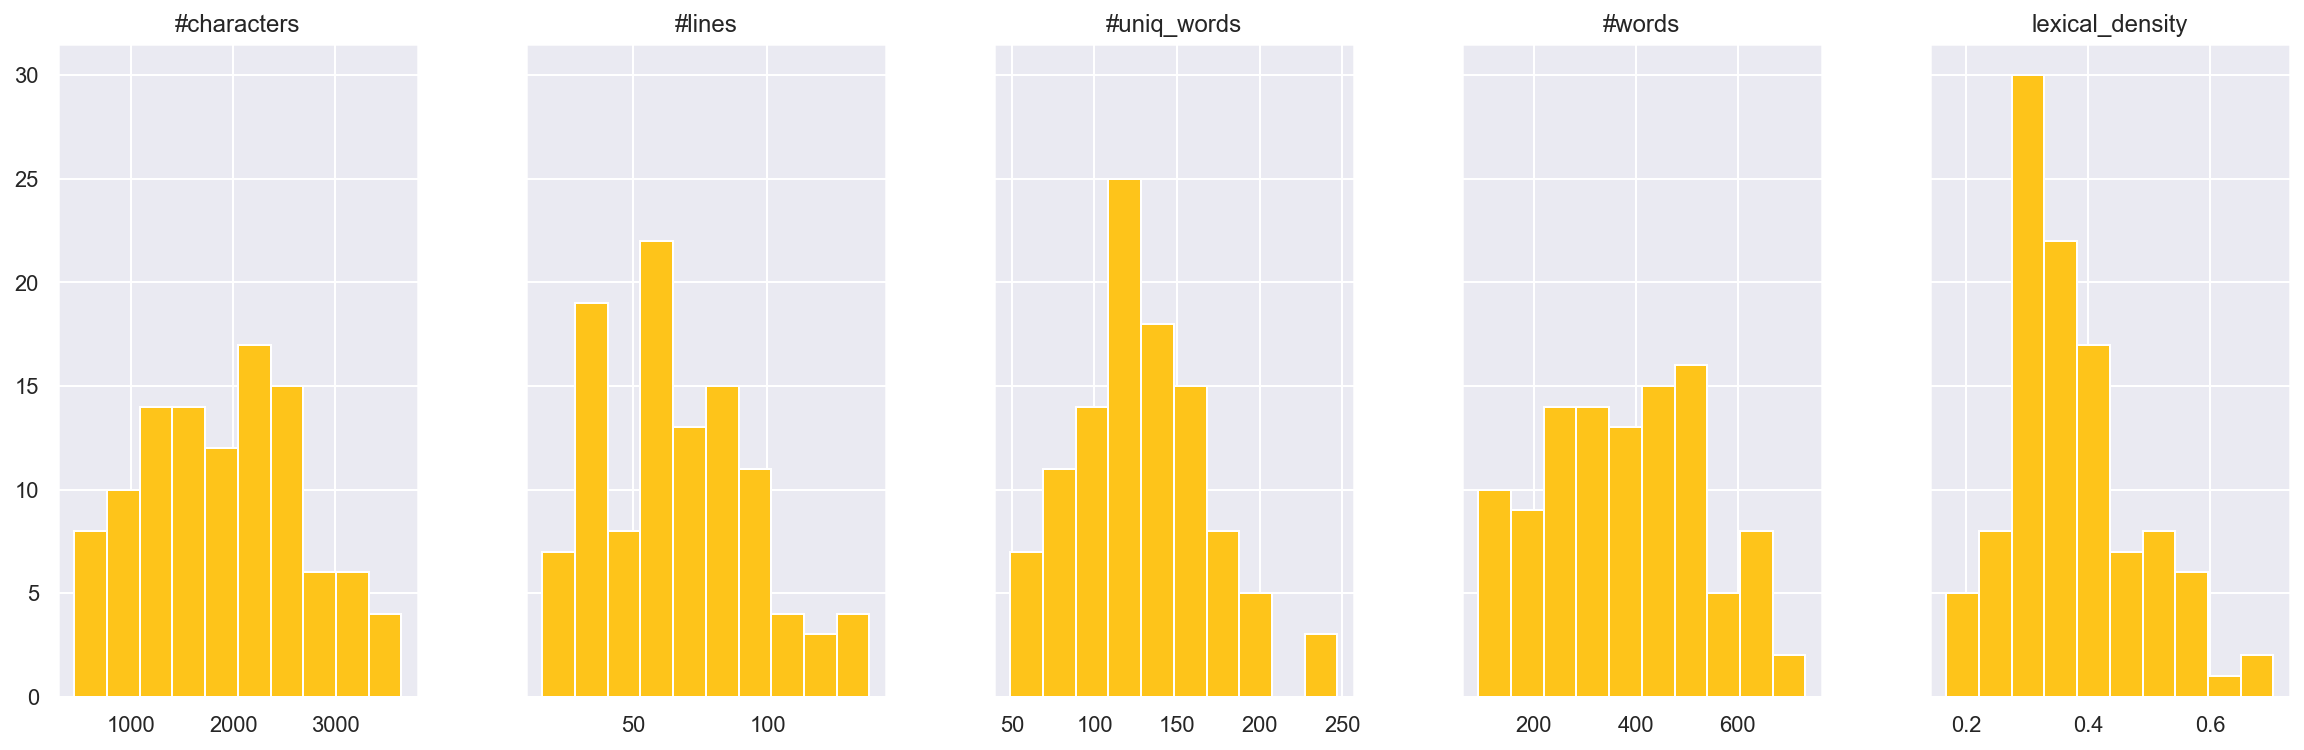

In [5]:
FE_COLS = ['#characters', '#words', '#lines', '#uniq_words', 'lexical_density']

df['#characters'] = df.lyrics.str.len()
df['#words'] = df.lyrics.str.split().str.len()
df['#lines'] = df.lyrics.str.split('\n').str.len()
df['#uniq_words'] = df.lyrics.apply(lambda x: len(set(x.split())))
df['lexical_density'] = df['#uniq_words'] / df['#words']


df[FE_COLS].hist(sharey=True, layout=(1, 5), color=MAIN_COLOR);

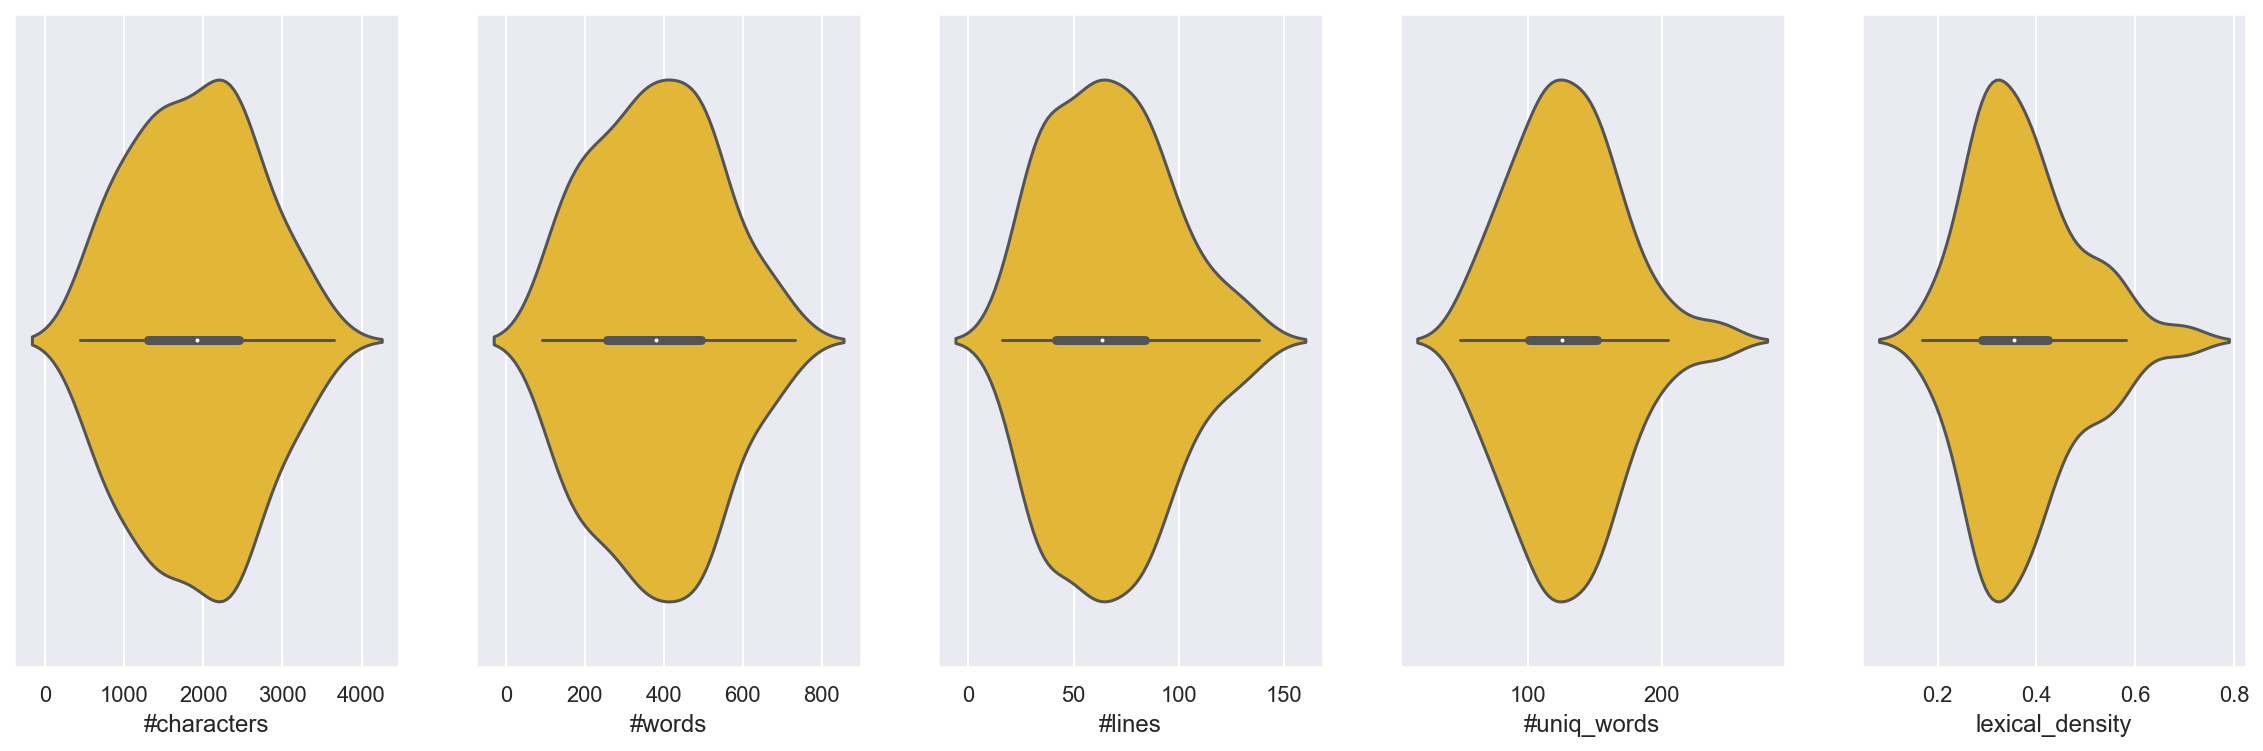

In [6]:
fig, axs = plt.subplots(ncols=len(FE_COLS))
for i, c in enumerate(FE_COLS):
    sns.violinplot(x=df[c], ax=axs[i], sharex=True, color=MAIN_COLOR)

### 3. Most common words

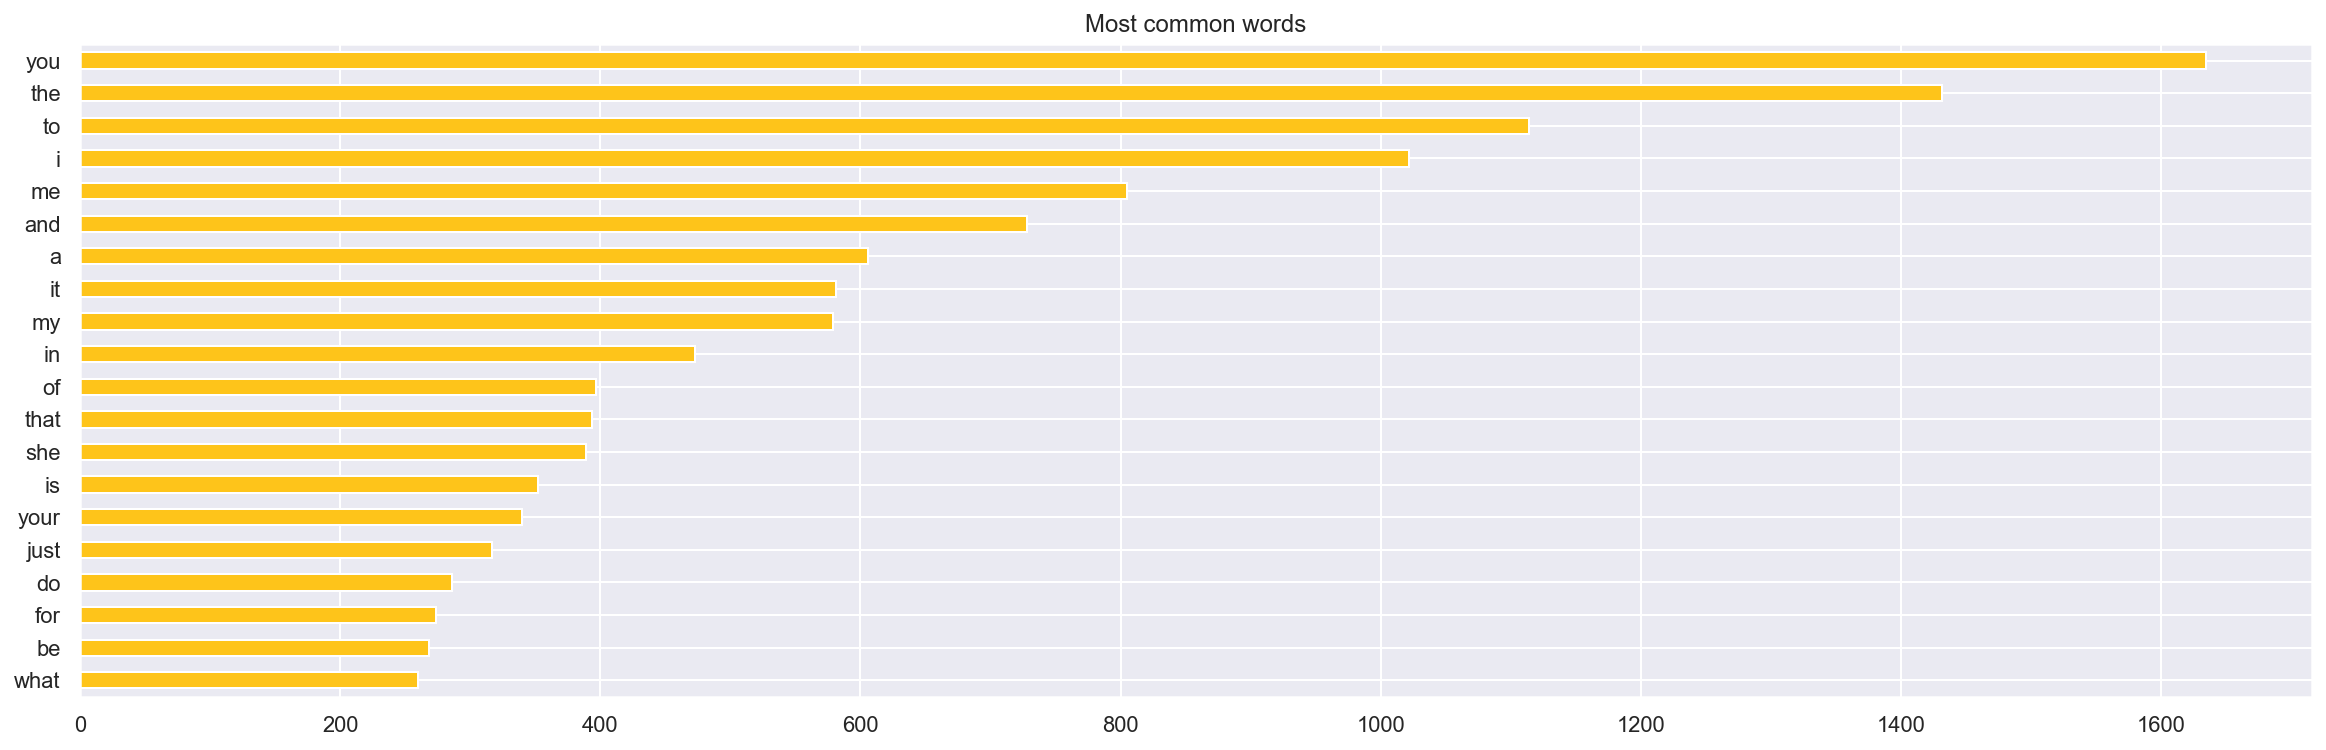

In [7]:
def top_values(series, num=20):
    """Return top values froma  """
    return series.value_counts()[:num][::-1]
    
title = "Most common words"
all_words_s = pd.Series(' '.join(df.lyrics).lower().split())
top_words = top_values(all_words_s)
top_words.plot(kind='barh', title=title, color=MAIN_COLOR);

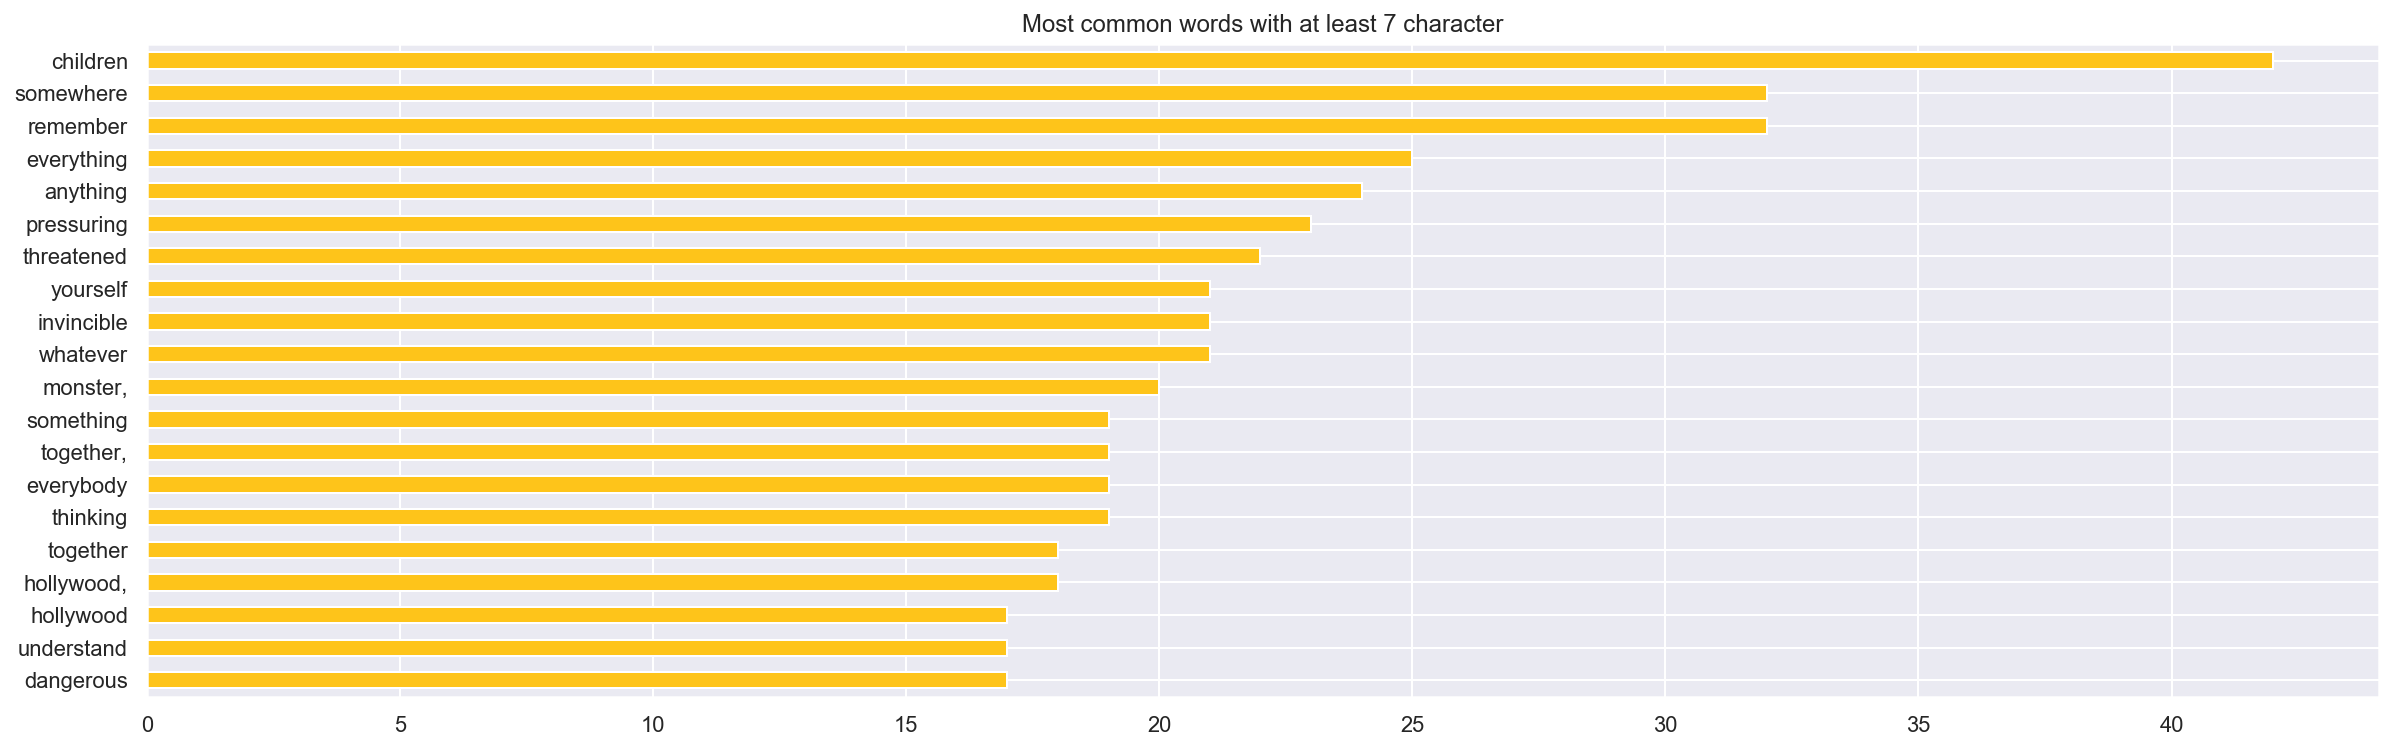

In [8]:
MIN_CHARS = 7
title = "Most common words with at least {} character".format(MIN_CHARS)
long_words_s = all_words_s.where(all_words_s.str.len() > MIN_CHARS)
top_long_words = long_words_s.value_counts()[:20][::-1]
top_long_words.plot(kind='barh', color=MAIN_COLOR, title=title);

### 4. Most common n-grams

##### 4.1 Bi-grams

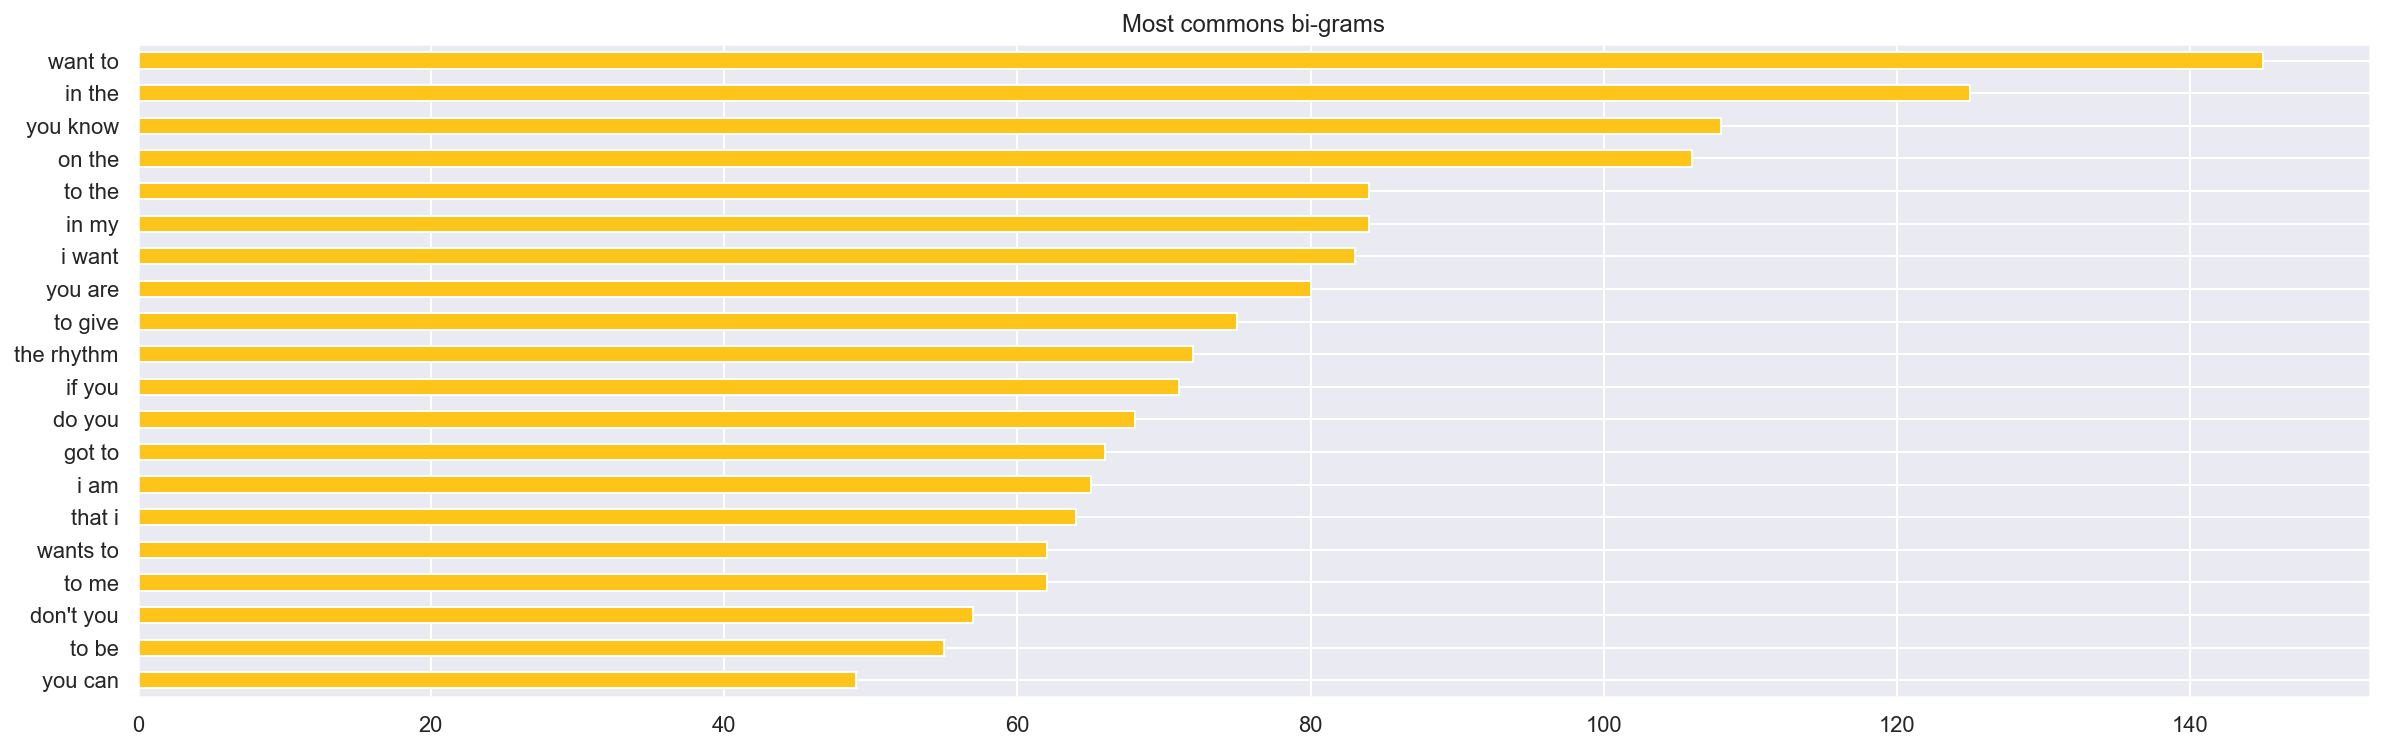

In [9]:
def get_ngrams_from_series(series, n=2):
    # using nltk.ngrams
    lines = ' '.join(series).lower().split('\n')
    lgrams = [ngrams(l.split(), n) for l in lines]
    grams = [[' '.join(g) for g in list(lg)] for lg in lgrams]
    return [item for sublist in grams for item in sublist]


title = "Most commons bi-grams"
bigrams_s = pd.Series(get_ngrams_from_series(df.lyrics, 2))
top_bigrams_s = bigrams_s.value_counts()[:20][::-1]
top_bigrams_s.plot(kind='barh', color=MAIN_COLOR, title=title);

#### 4.2 Tri-grams

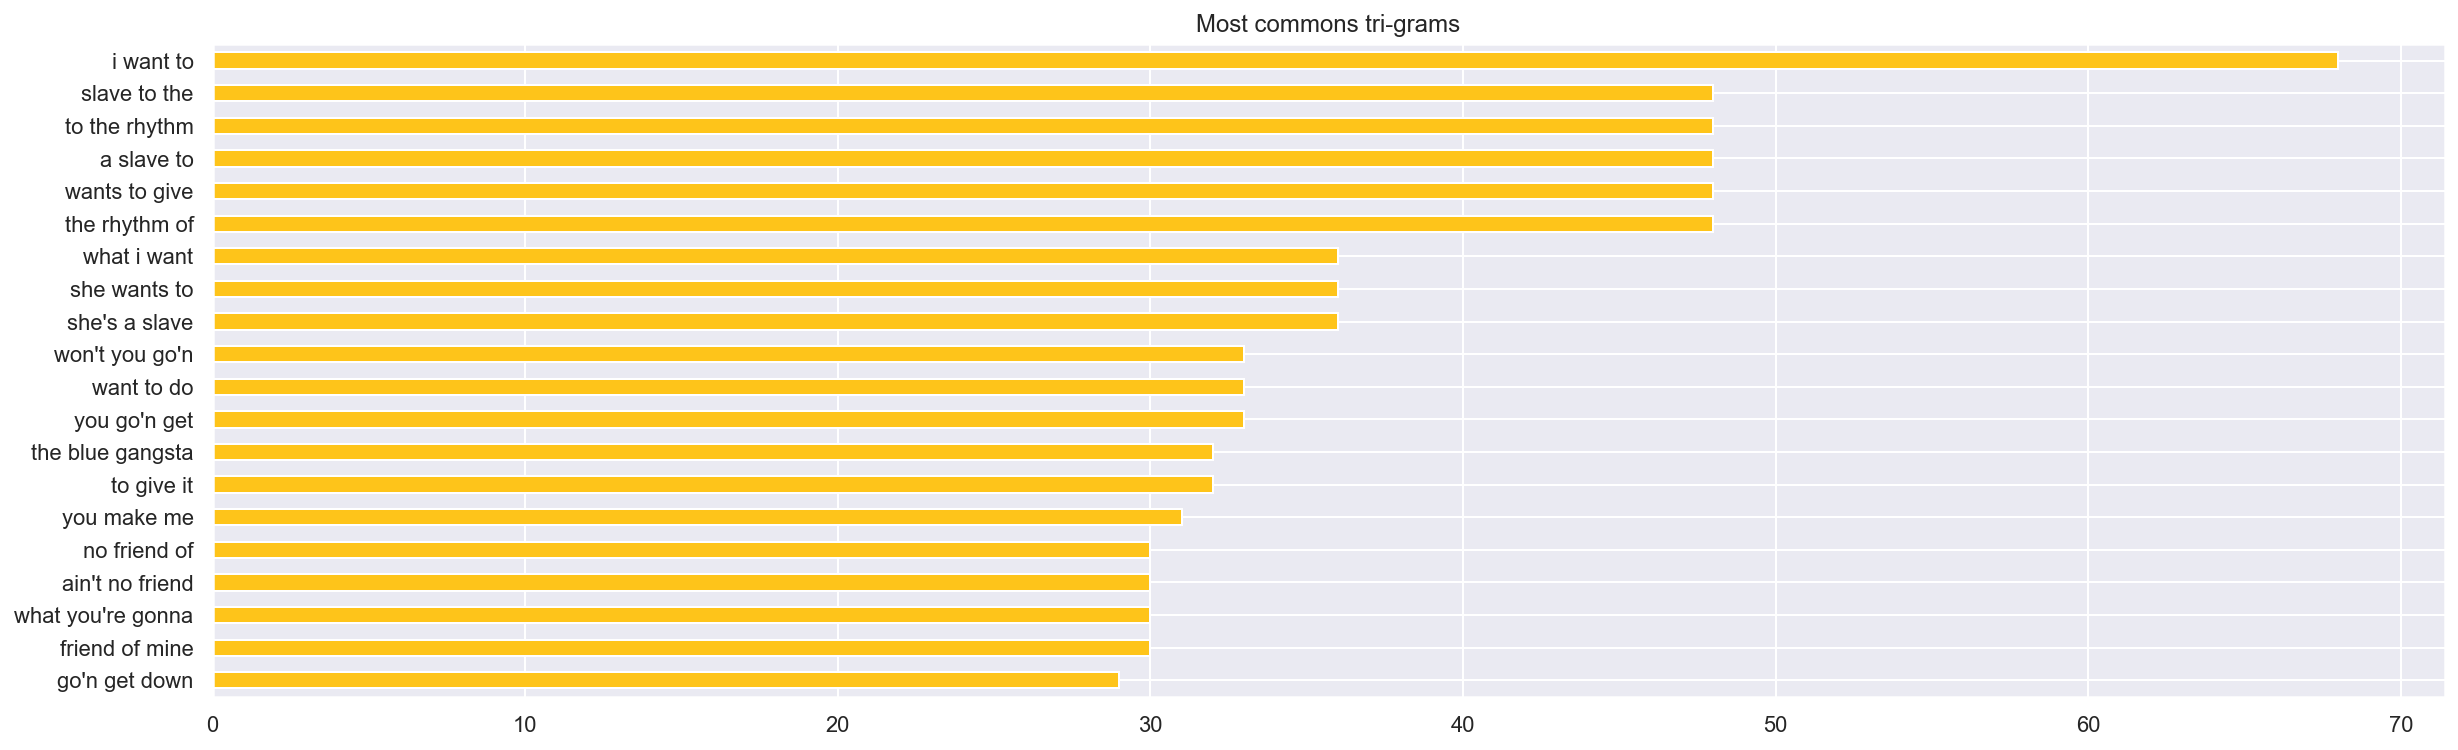

In [10]:
title = "Most commons tri-grams"
bigrams_s = pd.Series(get_ngrams_from_series(df.lyrics, 3))
top_bigrams_s = bigrams_s.value_counts()[:20][::-1]
top_bigrams_s.plot(kind='barh', color=MAIN_COLOR, title=title);

#### 4.3 four-grams

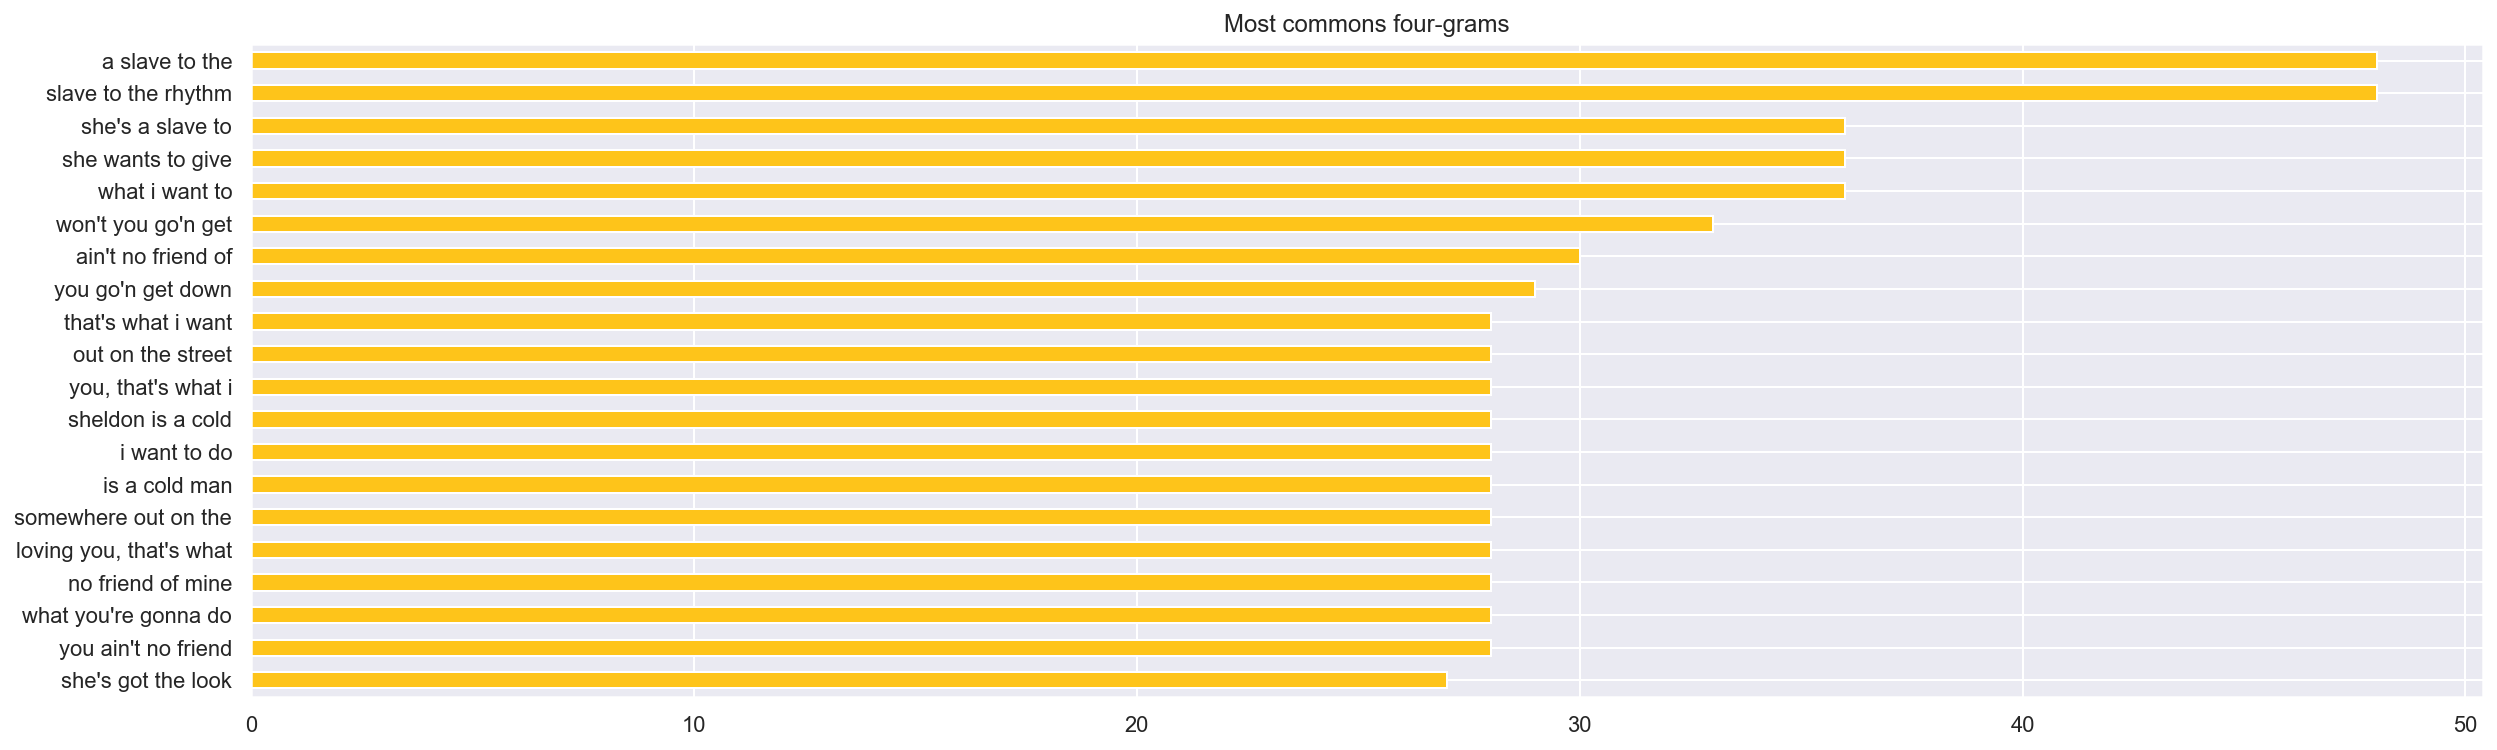

In [11]:
title = "Most commons four-grams"
bigrams_s = pd.Series(get_ngrams_from_series(df.lyrics, 4))
top_bigrams_s = bigrams_s.value_counts()[:20][::-1]
top_bigrams_s.plot(kind='barh', color=MAIN_COLOR, title=title);

### 5. Lyrics sentiment analysis

##### 5.1 Sentiment analysis

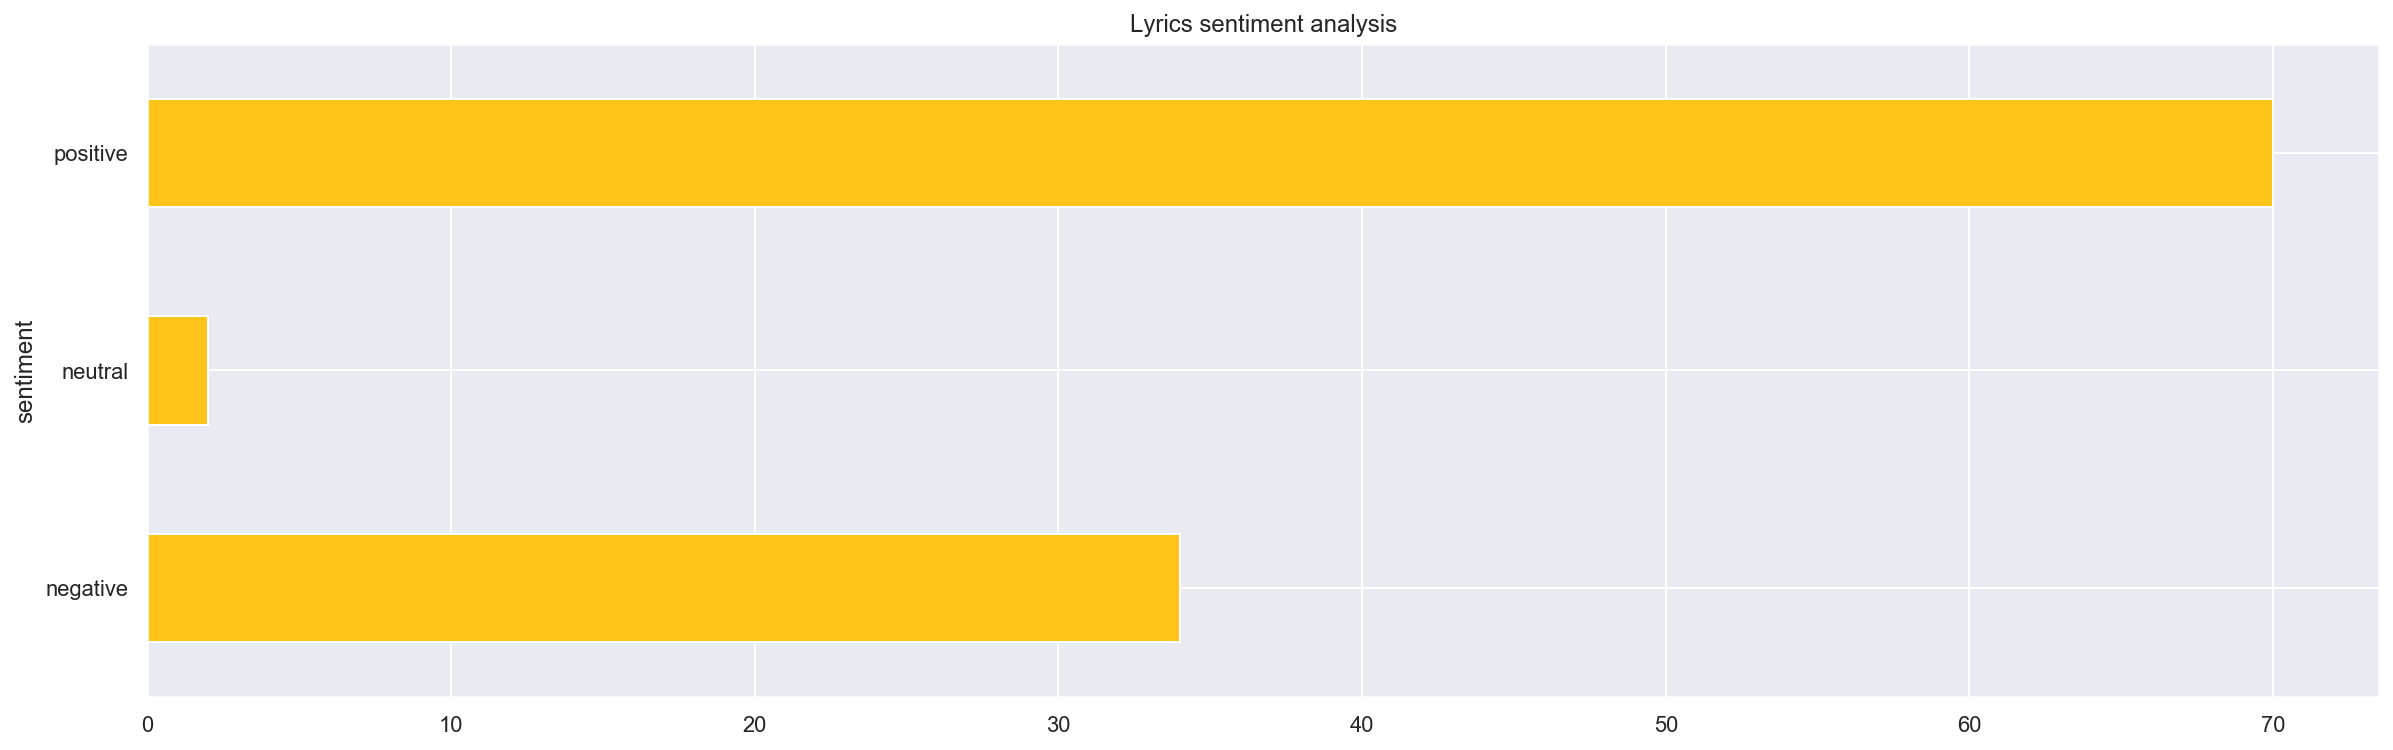

In [12]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
#nltk.download('vader_lexicon')

senti_analyze = SentimentIntensityAnalyzer()

df['sentiment_score'] = df.lyrics.apply(lambda l : senti_analyze.polarity_scores(l)['compound'])
df['sentiment'] = pd.cut(df['sentiment_score'], [-np.inf, -0.35, 0.35, np.inf], labels=['negative', 'neutral', 'positive'])

title = "Lyrics sentiment analysis"
df.groupby('sentiment').count()[['key']].plot(kind='barh', stacked=True, color=MAIN_COLOR, title=title, legend=False);


#### 5.2 Sentiment vs. unique words vs. lexical density

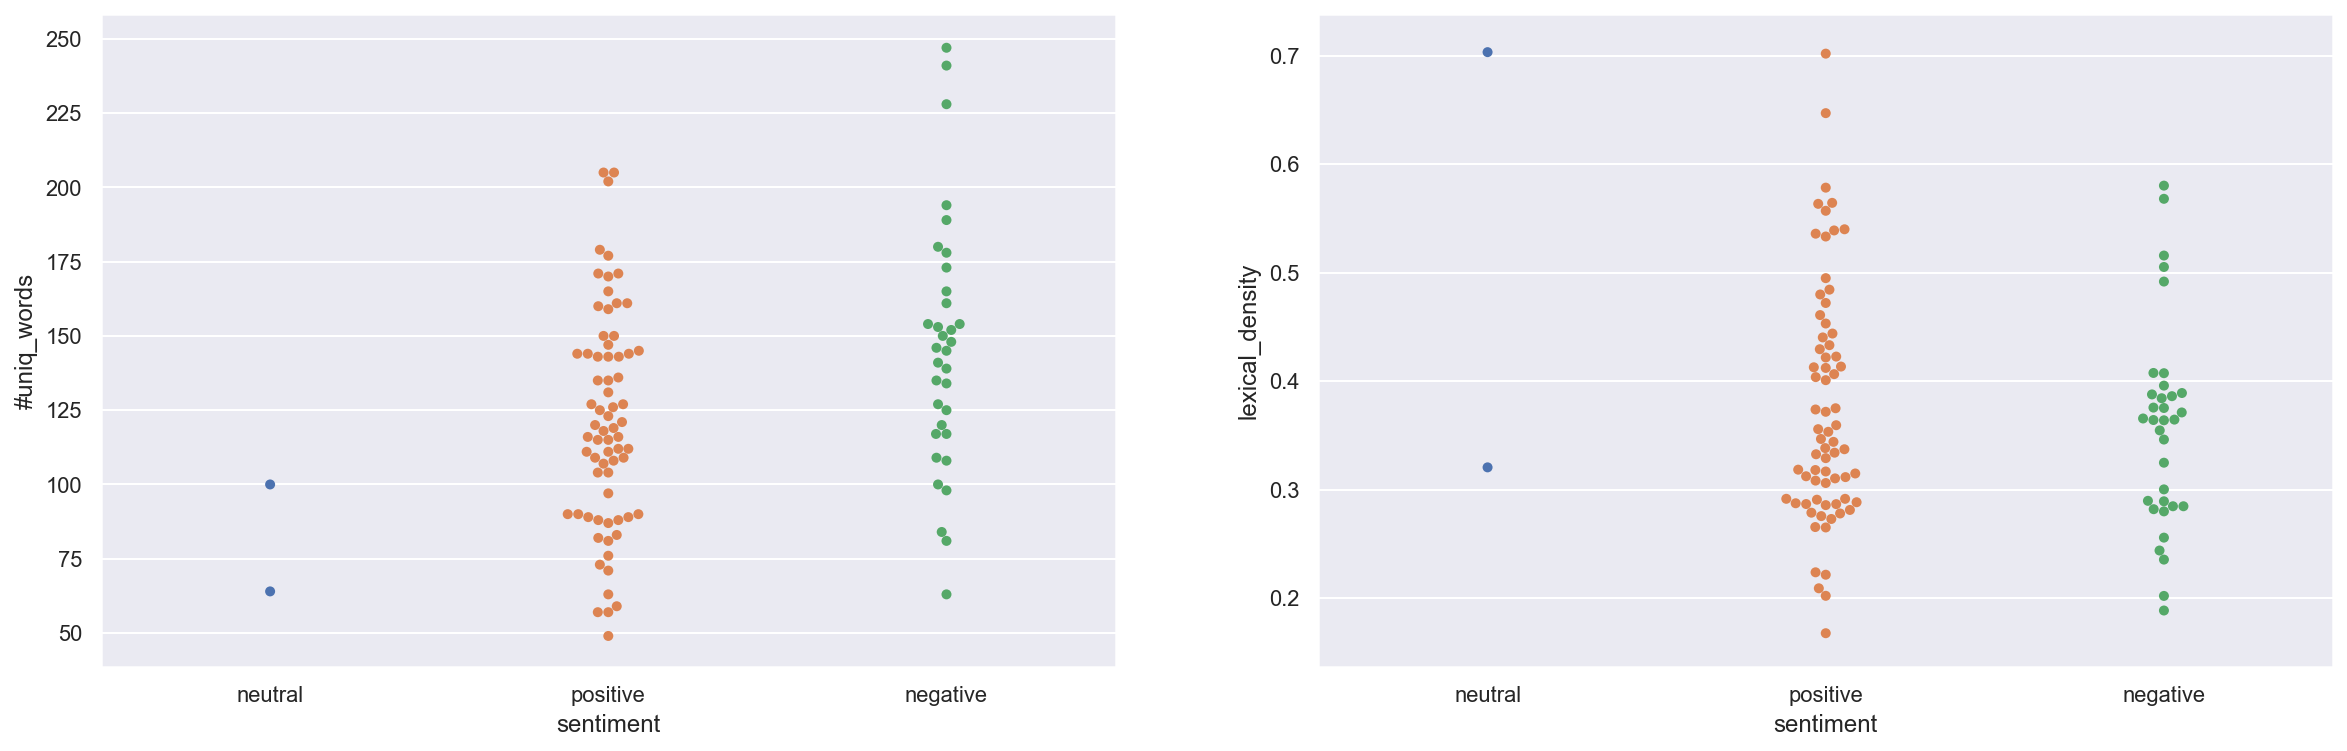

In [13]:
SELECTED_COLS = ['#uniq_words', 'lexical_density']

fig, axs = plt.subplots(ncols=len(SELECTED_COLS))
for i, c in enumerate(SELECTED_COLS):
    sns.swarmplot(x='sentiment', y=c, data=df, ax=axs[i], order=['neutral', 'positive', 'negative'])

**Negative songs generally have less lexical density and tend to have more unique words**

### 6. Topic modelling

#### 6.1 Text pre-processing

In [14]:
# adpapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Build the bigram and trigram models
bigram = gensim.models.Phrases(df.lyrics, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df.lyrics], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(df.lyrics)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
clean_lyrics = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


#### 6.2 Visualize LDA

In [15]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt


# Create Dictionary
id2word = corpora.Dictionary(clean_lyrics)

# Create Corpus
texts = clean_lyrics

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.007403  0.102160       1        1  18.157845
13    -0.161663  0.005515       2        1  10.042692
1      0.101005  0.178317       3        1   9.604601
12     0.091766  0.140366       4        1   7.118309
8      0.033043  0.205571       5        1   6.633150
19    -0.118008  0.001244       6        1   6.472733
18     0.079246  0.028376       7        1   5.380582
16    -0.263010  0.003337       8        1   4.128480
6      0.085288  0.029300       9        1   4.124680
9     -0.092144  0.011290      10        1   4.102245
17    -0.138074 -0.075717      11        1   4.066325
11    -0.035677  0.003892      12        1   3.948249
10    -0.099312 -0.053010      13        1   3.668512
0     -0.091294  0.049823      14        1   2.915209
2      0.072860 -0.172703      15        1   2.384139
7      0.107845  0.006823      16        1   1.976736
3      0.064897 -0.255353      17        1   1.868015
15     0.042848 -0.086967      18        1   1.298250
5      0.133593 -0.061449      19        1   1.072699
4      0.179388 -0.060816      20        1   1.036548, topic_info=          Term        Freq       Total Category  logprob  loglift
36        love  438.000000  438.000000  Default  30.0000  30.0000
92         get  445.000000  445.000000  Default  29.0000  29.0000
1814  euphoria  121.000000  121.000000  Default  28.0000  28.0000
344      happy  102.000000  102.000000  Default  27.0000  27.0000
114     really  153.000000  153.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
42        much    1.095904   33.584785  Topic20  -5.0674   1.1468
347       high    0.627870   10.817518  Topic20  -5.6244   1.7227
24          go    3.075115  339.767395  Topic20  -4.0357  -0.1356
54         say    0.984895  152.081207  Topic20  -5.1742  -0.4704
1406      sure    0.427747    5.335022  Topic20  -6.0082   2.0458

[972 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
949       1  0.915823     aaaah
472       5  0.970360      aaow
1703      7  0.934197  abortion
1161     12  0.663001    actual
1235      4  0.658414    afraid
...     ...       ...       ...
238      14  0.892416      year
425      13  0.493444  yearning
71       13  0.045198     young
71       14  0.926555     young
1854     17  0.867487     youth

[1594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 2, 13, 9, 20, 19, 17, 7, 10, 18, 12, 11, 1, 3, 8, 4, 16, 6, 5])

### 7. Lyrics PCA

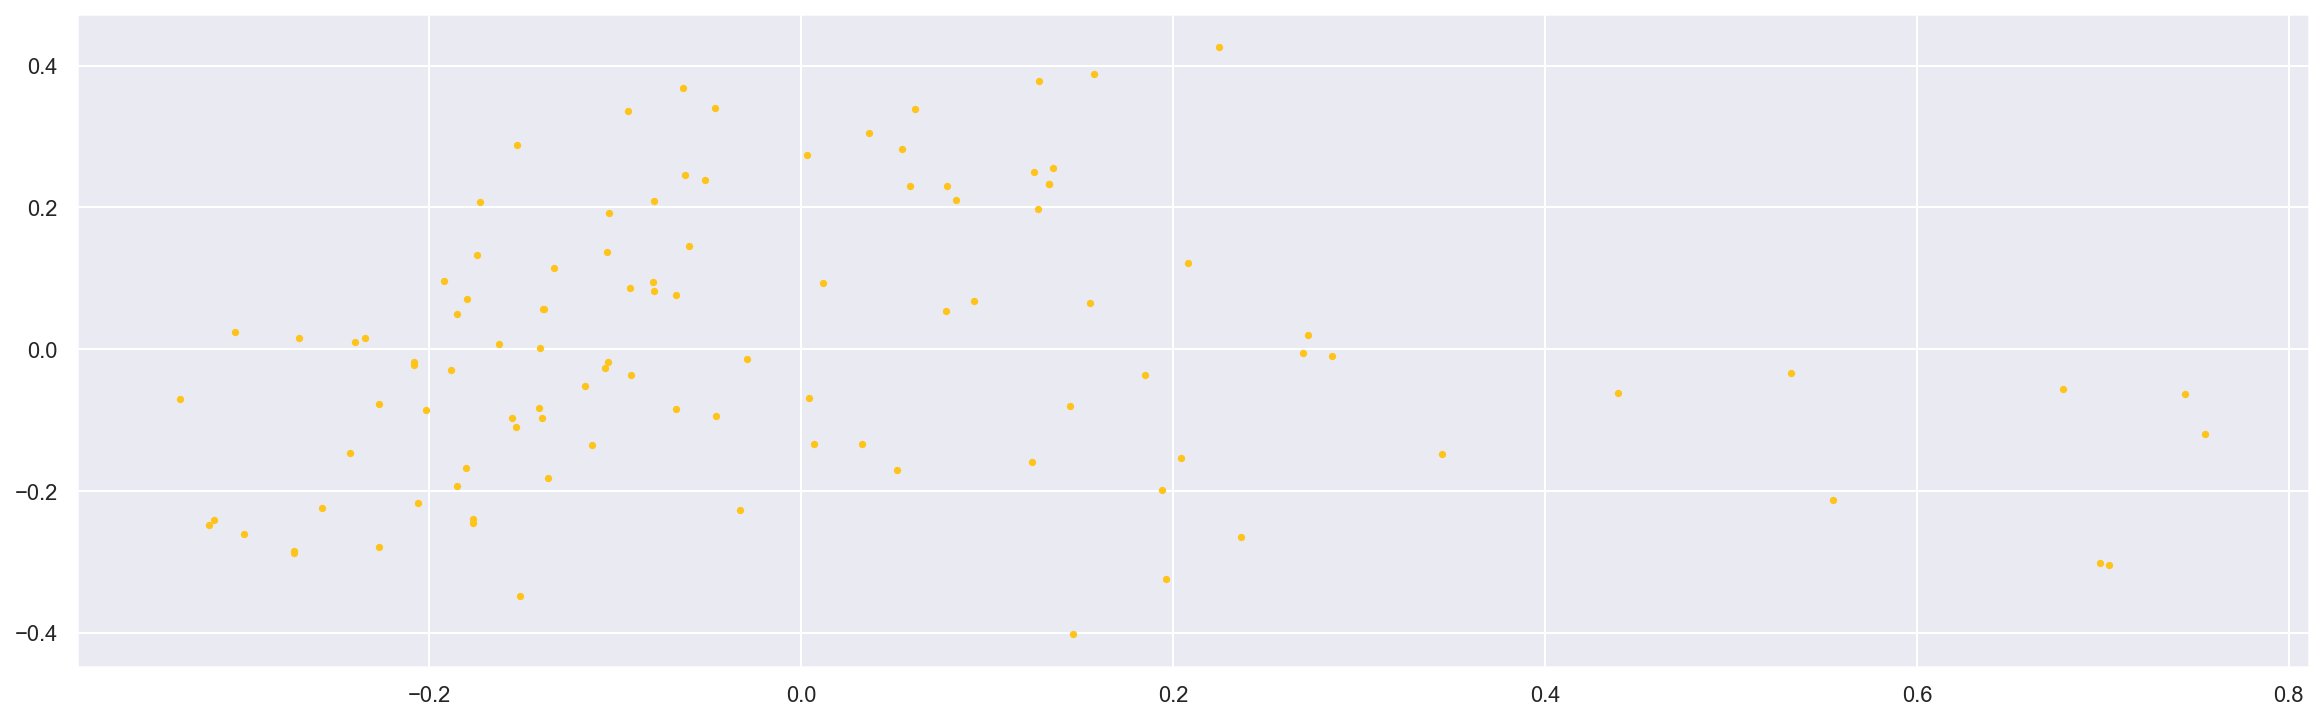

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

vectorizer = TfidfVectorizer(max_features=100)
vector = vectorizer.fit_transform(df.lyrics)
vector = vector.toarray()  # Convert csr_matrix to array
pca = PCA(2).fit_transform(vector)

plt.scatter(pca[:, 0], pca[:, 1], s=7, color=MAIN_COLOR)
plt.show()

- Comment: sparse distribution

### 8. K-means

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0).fit(vector)
kmeans.labels_

predicted_vector = kmeans.predict(vector)

#### 8.1 Get most common words for each cluster

In [18]:
def top_tf_idf(series, top_n=5):
    vectorizer = TfidfVectorizer(max_features=100, stop_words=stop_words)
    vector = vectorizer.fit_transform(series)
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(vector.toarray()).flatten()[::-1]
    return feature_array[tfidf_sorting][:top_n]

df['cluster'] = predicted_vector
most_common_words_cluster = df.groupby('cluster')['lyrics'].apply(lambda x: top_tf_idf(x, top_n=9))
for c in most_common_words_cluster:
    print(c)

['young' 'love' 'may' 'though' 'yet' 'word' 'recall' 'last' 'day']
['childhood' 'cause' 'things' 'world' 'say' 'like' 'way' 'never' 'love']
['euphoria' 'love' 'living' 'world' 'eyes' 'feel' 'heart' 'one' 'say']
['abortion' 'papers' 'child' 'words' 'love' 'life' 'like' 'think' 'god']
['rhythm' 'slave' 'dances' 'love' 'danced' 'must' 'home' 'dance' 'late']
['going' 'girl' 'leave' 'yeah' 'feel' 'never' 'got' 'oh' 'another']
